# Generate data and calculate similarity

The goal of this notebook is to determine how much of the structure in the original dataset (single experiment) is retained after adding some number of experiments.

The approach is to,
1. Generates simulated data by sampling from a trained VAE model.  Simulate ```num_simulated_samples```

    Here we are trying to simulate data from a single experiment type.  

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import random
from plotnine import ggplot, ggtitle, xlab, ylab, geom_point, geom_line, aes
from keras.models import load_model
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore')

sys.path.append("../")
from functions import generate_data
from functions import similarity_metric

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# User parameters
NN_architecture = 'NN_2500_30'
analysis_name = 'analysis_1'
num_simulated_samples = 100
experiment_id = 'E-GEOD-24036'
color_by_field = 'genotype'

In [3]:
# Input files

# base dir on repo
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../..")) 

# base dir on local machine for data storage
# os.makedirs doesn't recognize `~`
local_dir = local_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../..")) 

NN_dir = base_dir + "/models/" + NN_architecture
latent_dim = NN_architecture.split('_')[-1]

mapping_file = os.path.join(
    base_dir,
    "data",
    "metadata",
    "sample_annotations.tsv")

normalized_data_file = os.path.join(
    base_dir,
    "data",
    "input",
    "train_set_normalized.pcl")

model_encoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_encoder_model.h5".format(latent_dim)))[0]

weights_encoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_encoder_weights.h5".format(latent_dim)))[0]

model_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_decoder_model.h5".format(latent_dim)))[0]

weights_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_decoder_weights.h5".format(latent_dim)))[0]

In [4]:
# Output file
new_dir = os.path.join(local_dir, "Data", "Batch_effects", "simulated")

analysis_dir = os.path.join(new_dir, analysis_name)

if os.path.exists(analysis_dir):
    print('Directory already exists: \n {}'.format(analysis_dir))
else:
    print('Creating new directory: \n {}'.format(analysis_dir))
os.makedirs(analysis_dir, exist_ok=True)

    
simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

Directory already exists: 
 /home/alexandra/Documents/Data/Batch_effects/simulated/analysis_1


In [5]:
# Load saved models
loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

### Get experiment ids

In [6]:
# Read in metadata
metadata = pd.read_table(
    mapping_file, 
    header=0, 
    sep='\t', 
    index_col=0)

metadata.head()

,sample_name,ml_data_source,description,nucleic_acid,medium,genotype,od,growth_setting_1,growth_setting_2,strain,temperature,treatment,additional_notes,variant_phenotype,abx_marker,biotic_int_lv_2,biotic_int_lv_1
experiment,,,,,,,,,,,,,,,,,
E-GEOD-46947,GSM1141730 1,GSM1141730_PA01_ZnO_PZO_.CEL,Pseudomonas aeruginosa PAO1 LB aerated 5 h wi...,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,1 mM ZnO nanoparticles,Grown for 5h,NaN,NaN,NaN,NaN
E-GEOD-46947,GSM1141729 1,GSM1141729_PA01_none_PC_.CEL,Pseudomonas aeruginosa PAO1 LB aerated 5 h,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,NaN,Grown for 5h,NaN,NaN,NaN,NaN
E-GEOD-65882,GSM1608059 1,GSM1608059_Planktonic_1.CEL,PAO1 WT. Planktonic. Rep1,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
E-GEOD-65882,GSM1608060 1,GSM1608060_Planktonic_2.CEL,PAO1 WT. Planktonic. Rep2,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
E-GEOD-65882,GSM1608061 1,GSM1608061_Planktonic_3.CEL,PAO1 WT. Planktonic. Rep3,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN


In [7]:
map_experiment_sample = metadata[['sample_name', 'ml_data_source']]
map_experiment_sample.head()

,sample_name,ml_data_source
experiment,,
E-GEOD-46947,GSM1141730 1,GSM1141730_PA01_ZnO_PZO_.CEL
E-GEOD-46947,GSM1141729 1,GSM1141729_PA01_none_PC_.CEL
E-GEOD-65882,GSM1608059 1,GSM1608059_Planktonic_1.CEL
E-GEOD-65882,GSM1608060 1,GSM1608060_Planktonic_2.CEL
E-GEOD-65882,GSM1608061 1,GSM1608061_Planktonic_3.CEL


In [8]:
experiment_ids = np.unique(np.array(map_experiment_sample.index))
print("There are {} experiments in the compendium".format(len(experiment_ids)))

There are 135 experiments in the compendium


### Set user selected experiment id or randomly select experiment id

In [9]:
if not experiment_id:
    selected_experiment_id = np.random.RandomState(randomState).choice(experiment_ids)
else:
    selected_experiment_id = experiment_id

### Get samples belonging to selected experiment

In [10]:
selected_metadata = metadata.loc[selected_experiment_id]
selected_metadata.head()

,sample_name,ml_data_source,description,nucleic_acid,medium,genotype,od,growth_setting_1,growth_setting_2,strain,temperature,treatment,additional_notes,variant_phenotype,abx_marker,biotic_int_lv_2,biotic_int_lv_1
experiment,,,,,,,,,,,,,,,,,
E-GEOD-24036,GSM591496 1,GSM591496.CEL,"Pseudomonas aeruginosa PA14 WT, grown in LB, n...",RNA,LB,WT,2,Planktonic,Shaking,PA14,37.0,no treatment,NaN,NaN,NaN,NaN,NaN
E-GEOD-24036,GSM591601 1,GSM591601.CEL,"Pseudomonas aeruginosa PA14 WT, grown in LB, n...",RNA,LB,WT,2,Planktonic,Shaking,PA14,37.0,no treatment,NaN,NaN,NaN,NaN,NaN
E-GEOD-24036,GSM591602 1,GSM591602.CEL,"Pseudomonas aeruginosa PA14 WT, grown in LB, n...",RNA,LB,WT,2,Planktonic,Shaking,PA14,37.0,no treatment,NaN,NaN,NaN,NaN,NaN
E-GEOD-24036,GSM591603 1,GSM591603.CEL,"Pseudomonas aeruginosa PA14 WT, grown in LB w...",RNA,LB,WT,2,Planktonic,Shaking,PA14,37.0,2-AA (3mM),NaN,NaN,NaN,NaN,NaN
E-GEOD-24036,GSM591622 1,GSM591622.CEL,"Pseudomonas aeruginosa PA14 WT, grown in LB w...",RNA,LB,WT,2,Planktonic,Shaking,PA14,37.0,2-AA (3mM),NaN,NaN,NaN,NaN,NaN


In [11]:
print("There are {} samples in experiment {}".format(selected_metadata.shape[0], selected_experiment_id))

There are 18 samples in experiment E-GEOD-24036


In [12]:
sample_ids = list(selected_metadata['ml_data_source'])
sample_ids

['GSM591496.CEL',
 'GSM591601.CEL',
 'GSM591602.CEL',
 'GSM591603.CEL',
 'GSM591622.CEL',
 'GSM591623.CEL',
 'GSM591624.CEL',
 'GSM591625.CEL',
 'GSM591627.CEL',
 'GSM597216.CEL',
 'GSM597217.CEL',
 'GSM597218.CEL',
 'GSM597219.CEL',
 'GSM597220.CEL',
 'GSM597221.CEL',
 'GSM597329.CEL',
 'GSM597330.CEL',
 'GSM597331.CEL']

In [13]:
normalized_data = pd.read_table(
    normalized_data_file,
    header=0,
    sep='\t',
    index_col=0).T

normalized_data.head()

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb22ffd44a8>]],
      dtype=object)

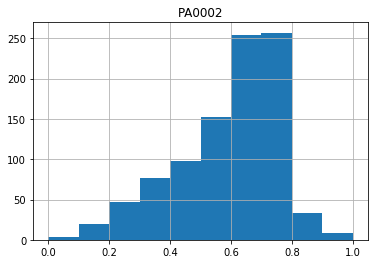

In [14]:
normalized_data.hist(column='PA0002')

In [15]:
# Check that samples are in gene expression dataset otherwise exit
if any(x in list(normalized_data.index) for x in sample_ids):
    print('found')
else:
    print('not found')

found


In [16]:
selected_data_df = normalized_data.loc[sample_ids]

selected_data_df.head()

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM591496.CEL,0.758438,0.808715,0.626747,0.774033,0.514039,0.383739,0.343325,0.719577,0.541627,0.216560,...,0.245720,0.671244,0.670357,0.767884,0.640626,0.151623,0.659674,0.643497,0.746590,0.707505
GSM591601.CEL,0.702824,0.755786,0.537629,0.755608,0.462175,0.316667,0.308082,0.704596,0.558551,0.160684,...,0.214021,0.653341,0.668257,0.686663,0.630709,0.182788,0.703150,0.649179,0.739723,0.728428
GSM591602.CEL,0.776721,0.736631,0.582667,0.749297,0.486610,0.302209,0.323932,0.782628,0.807336,0.225348,...,0.171650,0.560667,0.688716,0.699709,0.647261,0.163239,0.589900,0.649514,0.724675,0.696667
GSM591603.CEL,0.650666,0.733063,0.484848,0.682237,0.404460,0.314539,0.461867,0.569701,0.396897,0.201233,...,0.248430,0.533048,0.536321,0.565483,0.565437,0.290283,0.518061,0.411037,0.675788,0.625928
GSM591622.CEL,0.667370,0.710359,0.466625,0.627510,0.389397,0.330307,0.557265,0.504433,0.340656,0.158090,...,0.247211,0.480189,0.524795,0.570522,0.514418,0.238918,0.437085,0.393830,0.658838,0.614567


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb22ff29d68>]],
      dtype=object)

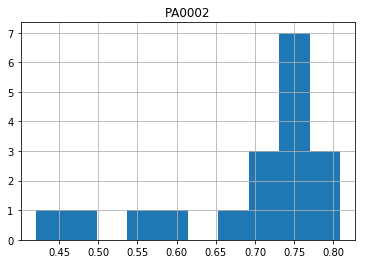

In [17]:
selected_data_df.hist(column='PA0002')

### Embed samples into latent space using trained VAE

In [18]:
# Encode into latent space
data_encoded = loaded_model.predict_on_batch(selected_data_df)
data_encoded_df = pd.DataFrame(data_encoded, index=selected_data_df.index)

data_encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
GSM591496.CEL,0.0,0.000000,2.319957,0.0,0.248557,4.816005,0.0,0.0,3.494926,5.298022,...,0.000000,0.0,0.513655,4.027642,2.254136,0.0,0.111289,2.762950,0.0,0.000000
GSM591601.CEL,0.0,0.105274,2.417805,0.0,0.623933,4.440513,0.0,0.0,2.778685,4.065911,...,0.000000,0.0,0.891980,3.340123,1.900610,0.0,0.000000,3.077000,0.0,0.000000
GSM591602.CEL,0.0,0.081273,2.659945,0.0,0.612093,4.991161,0.0,0.0,3.569157,4.860400,...,0.000000,0.0,0.914119,1.246660,3.097568,0.0,0.000000,2.688240,0.0,0.000000
GSM591603.CEL,0.0,1.320578,3.445772,0.0,0.248308,6.596386,0.0,0.0,0.226627,1.418302,...,0.000000,0.0,0.664482,2.135759,2.746596,0.0,0.000000,0.410463,0.0,0.295563
GSM591622.CEL,0.0,1.321950,3.624446,0.0,0.290001,6.581908,0.0,0.0,0.000000,1.033994,...,0.358296,0.0,0.796658,2.299481,2.677809,0.0,0.000000,0.601242,0.0,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb22de9ada0>]],
      dtype=object)

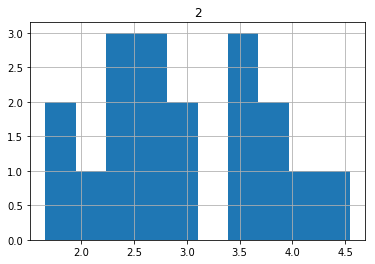

In [19]:
data_encoded_df.hist(column=2)

In [20]:
data_encoded_df.shape

(18, 30)

### Get centroid of samples in experiment

In [21]:
centroid = data_encoded_df.mean(axis=0)
centroid

0     0.058502
1     2.293353
2     3.005042
3     0.058505
4     0.419318
5     5.070214
6     0.000000
7     0.183326
8     1.273130
9     2.309329
10    0.033211
11    0.412933
12    0.002946
13    0.146355
14    0.391908
15    0.177576
16    0.010339
17    0.106363
18    0.245415
19    0.258470
20    0.019905
21    0.066436
22    0.848714
23    1.980588
24    1.788094
25    0.000000
26    0.032967
27    1.196640
28    0.223923
29    0.270426
dtype: float32

### Generate simulated gene expression data 

Shift samples in a different direction while maintaining the distance between samples.

The below implementation is considering each pair of closest points simulating a new sample by stepping in a random direction but preserving the distance between those two point.  Thus, by design, this implementation is preserving local structure of the experiment but not necessarily the global strucuture.

In [22]:
"""
# Shift all samples in the experiment by the vector(centroid, new_centroid)
randomState = 123
seed(randomState)
# Encode original gene expression data into latent space
data_encoded_all = loaded_model.predict_on_batch(normalized_data)
data_encoded_all_df = pd.DataFrame(data_encoded_all, index=normalized_data.index)

data_encoded_all_df.head()

# Find a new location in the latent space by sampling from the latent space
encoded_means = data_encoded_all_df.mean(axis=0)
encoded_stds = data_encoded_all_df.std(axis=0)

latent_dim = int(latent_dim)
new_centroid = np.zeros(latent_dim)

for j in range(latent_dim):
    # Use mean and std per feature
    new_centroid[j] = np.random.normal(
        encoded_means[j], encoded_stds[j])

# Get vector between the original centroid and the new centroid
#print(new_centroid)
#print(centroid)
shift_vec = new_centroid - centroid
#print(shift_vec)

simulated_data_encoded_df = data_encoded_df + shift_vec

simulated_data_encoded_df.head()"""

'\n# Shift all samples in the experiment by the vector(centroid, new_centroid)\nrandomState = 123\nseed(randomState)\n# Encode original gene expression data into latent space\ndata_encoded_all = loaded_model.predict_on_batch(normalized_data)\ndata_encoded_all_df = pd.DataFrame(data_encoded_all, index=normalized_data.index)\n\ndata_encoded_all_df.head()\n\n# Find a new location in the latent space by sampling from the latent space\nencoded_means = data_encoded_all_df.mean(axis=0)\nencoded_stds = data_encoded_all_df.std(axis=0)\n\nlatent_dim = int(latent_dim)\nnew_centroid = np.zeros(latent_dim)\n\nfor j in range(latent_dim):\n    # Use mean and std per feature\n    new_centroid[j] = np.random.normal(\n        encoded_means[j], encoded_stds[j])\n\n# Get vector between the original centroid and the new centroid\n#print(new_centroid)\n#print(centroid)\nshift_vec = new_centroid - centroid\n#print(shift_vec)\n\nsimulated_data_encoded_df = data_encoded_df + shift_vec\n\nsimulated_data_encoded

In [23]:
# Add individual vectors(centroid, sample point) to new_centroid
randomState = 123
seed(randomState)
# Encode original gene expression data into latent space
data_encoded_all = loaded_model.predict_on_batch(normalized_data)
data_encoded_all_df = pd.DataFrame(data_encoded_all, index=normalized_data.index)

data_encoded_all_df.head()

# Find a new location in the latent space by sampling from the latent space
encoded_means = data_encoded_all_df.mean(axis=0)
encoded_stds = data_encoded_all_df.std(axis=0)

latent_dim = int(latent_dim)
new_centroid = np.zeros(latent_dim)

for j in range(latent_dim):
    new_centroid[j] = np.random.normal(
        encoded_means[j], encoded_stds[j])

# Shift samples based on using same distance and direction of each sample in reference to centroid
simulated_data_encoded_df = data_encoded_df.copy()

for sample_id in data_encoded_df.index:
    shift_vec = data_encoded_df.loc[sample_id] - centroid
    simulated_data_encoded_df.loc[sample_id] = new_centroid + shift_vec

simulated_data_encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
GSM591496.CEL,-0.864164,0.034925,0.526230,-1.534062,-0.274471,3.488247,-2.75769,-0.034725,4.523311,2.508502,...,1.485993,2.72202,-0.748979,5.159904,-0.742386,-0.358271,1.847986,0.257558,0.203088,-0.848333
GSM591601.CEL,-0.864164,0.140199,0.624078,-1.534062,0.100906,3.112754,-2.75769,-0.034725,3.807070,1.276391,...,1.485993,2.72202,-0.370654,4.472385,-1.095912,-0.358271,1.736697,0.571608,0.203088,-0.848333
GSM591602.CEL,-0.864164,0.116199,0.866218,-1.534062,0.089066,3.663403,-2.75769,-0.034725,4.597542,2.070880,...,1.485993,2.72202,-0.348516,2.378921,0.101046,-0.358271,1.736697,0.182848,0.203088,-0.848333
GSM591603.CEL,-0.864164,1.355503,1.652044,-1.534062,-0.274719,5.268628,-2.75769,-0.034725,1.255012,-1.371218,...,1.485993,2.72202,-0.598152,3.268021,-0.249926,-0.358271,1.736697,-2.094929,0.203088,-0.552769
GSM591622.CEL,-0.864164,1.356875,1.830719,-1.534062,-0.233027,5.254149,-2.75769,-0.034725,1.028385,-1.755526,...,1.844288,2.72202,-0.465976,3.431742,-0.318714,-0.358271,1.736697,-1.904150,0.203088,-0.848333


In [24]:
data_encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
GSM591496.CEL,0.0,0.000000,2.319957,0.0,0.248557,4.816005,0.0,0.0,3.494926,5.298022,...,0.000000,0.0,0.513655,4.027642,2.254136,0.0,0.111289,2.762950,0.0,0.000000
GSM591601.CEL,0.0,0.105274,2.417805,0.0,0.623933,4.440513,0.0,0.0,2.778685,4.065911,...,0.000000,0.0,0.891980,3.340123,1.900610,0.0,0.000000,3.077000,0.0,0.000000
GSM591602.CEL,0.0,0.081273,2.659945,0.0,0.612093,4.991161,0.0,0.0,3.569157,4.860400,...,0.000000,0.0,0.914119,1.246660,3.097568,0.0,0.000000,2.688240,0.0,0.000000
GSM591603.CEL,0.0,1.320578,3.445772,0.0,0.248308,6.596386,0.0,0.0,0.226627,1.418302,...,0.000000,0.0,0.664482,2.135759,2.746596,0.0,0.000000,0.410463,0.0,0.295563
GSM591622.CEL,0.0,1.321950,3.624446,0.0,0.290001,6.581908,0.0,0.0,0.000000,1.033994,...,0.358296,0.0,0.796658,2.299481,2.677809,0.0,0.000000,0.601242,0.0,0.000000


In [25]:
#data_encoded_all_df.hist(column=2)

In [26]:
#simulated_data_encoded_df.hist(column=2)

### Decode simulated data into gene space

In [27]:
# Decode simulated data into raw gene space
simulated_data_decoded = loaded_decode_model.predict_on_batch(simulated_data_encoded_df)
simulated_data_decoded_df = pd.DataFrame(simulated_data_decoded, 
                                         index=simulated_data_encoded_df.index,
                                         columns=normalized_data.columns)

simulated_data_decoded_df['color_by'] = list(selected_metadata[color_by_field])
simulated_data_decoded_df.head()

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,color_by
GSM591496.CEL,0.716235,0.722521,0.550284,0.781728,0.382075,0.376911,0.187648,0.686413,0.576014,0.188618,...,0.666533,0.686535,0.618826,0.592034,0.210841,0.616938,0.635691,0.699259,0.703332,WT
GSM591601.CEL,0.671763,0.694967,0.524684,0.744123,0.377686,0.392847,0.204651,0.661407,0.564257,0.193549,...,0.632662,0.648290,0.583319,0.569902,0.240132,0.582392,0.609698,0.689515,0.685755,WT
GSM591602.CEL,0.662964,0.684820,0.499886,0.714164,0.394631,0.358848,0.215361,0.689313,0.585831,0.186751,...,0.620469,0.622327,0.567399,0.592772,0.251368,0.607668,0.613036,0.681371,0.692554,WT
GSM591603.CEL,0.560606,0.635455,0.412246,0.648072,0.261233,0.335580,0.333812,0.533974,0.385565,0.187591,...,0.506201,0.522699,0.439251,0.436957,0.283630,0.519070,0.413123,0.548184,0.588067,WT
GSM591622.CEL,0.548742,0.629706,0.413317,0.647877,0.252968,0.347577,0.335489,0.526683,0.383801,0.186379,...,0.487951,0.516444,0.435390,0.422478,0.285696,0.507762,0.393627,0.540563,0.591449,WT


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb22ff3e198>]],
      dtype=object)

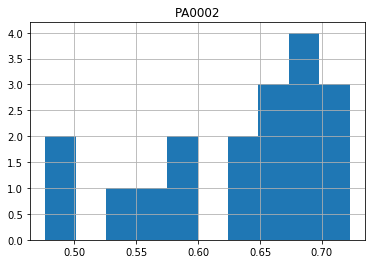

In [28]:
simulated_data_decoded_df.hist(column='PA0002')

In [29]:
# Save simulated data
simulated_data_decoded_df.to_csv(simulated_data_file, float_format='%.3f', sep='\t', compression='xz')